# Project 2: Continuous Control

---

### Preliminary actions

In [1]:
# Importing the necessary packages
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

from collections import deque
from unityagents import UnityEnvironment

from ddpg_agent import Agent

device: cpu


**IMPORTANT**: introduce in the following cell, in `file_name`, the path to the file of the REACHER evironment.

In [2]:
# Launching the environment
#env = UnityEnvironment(file_name='Reacher.app')      # single-agent version
env = UnityEnvironment(file_name='Reacher-20.app')    # 20-agent version

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity ML-Agents environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# Getting and selecting the default brain
brain_names = env.brain_names
print('Number of available brains:',len(brain_names))
print('Name of the brains:',brain_names)

brain_name = brain_names[0]          # Getting the name of the first brain
brain = env.brains[brain_name]       # Initializing the brain
print(brain)

Number of available brains: 1
Name of the brains: ['ReacherBrain']
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# Reseting the environment
env_data = env.reset(train_mode=True)[brain_name]

# Number of agents in the environment
num_agents = len(env_data.agents)
print('Number of agents:', num_agents)

# Action space size
action_size = brain.vector_action_space_size
print('Action space size:', action_size)

# State space size 
states = env_data.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Action space size: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Training the Agent with DDPG algorithm

In [5]:
# Hyperparameters definition
hyperparameters = {
    'FC1': 128,               # Actor/Critic network: nodes at 1st hidden layer
    'FC2': 128,               # Actor/Critic network: nodes at 2nd hidden layer
    'BUFFER_SIZE': int(1e5),  # Replay buffer size
    'BATCH_SIZE': 128,        # Minibatch size
    'GAMMA': 0.93,            # Discount factor
    'TAU': 1e-3,              # For soft update of target parameters
    'LR_ACTOR': 5e-4,         # Learning rate of the actor
    'LR_CRITIC': 1e-4,        # Learning rate of the critic
    'WEIGHT_DECAY': 0,        # Critic network L2 weight decay
    'UPDATE_EVERY': 20,       # Update rate
    'N_UPDATES': 10,          # Update passes
    'MU': 0.0,                # Parameter for Ornstein-Uhlenbeck noise
    'SIGMA': 0.05,            # Parameter for Ornstein-Uhlenbeck noise
    'THETA': 0.10,            # Parameter for Ornstein-Uhlenbeck noise
    'RANDOM_SEED': 4          # Seed for random generation (to allow repetitiveness)
     }

In [6]:
# Initializing the DDPG agent (from ddpg_agent.py file)
agent = Agent(state_size=state_size, action_size=action_size, hyperparameters=hyperparameters)

In [7]:
# Defining the training process
def ddpg_training(n_episodes=200, print_every=10):
    scores_window = deque(maxlen=100)               # Initialize list of last 100 scores
    scores = []                                     # Initialize list containing score for each episode
    not_solved = True                               # initialize not_solved contro
    solved_episode = 0                              # Initialize episode for average score over threshold
    solved_av_score = 0                             # Initialize average score when solved
    max_av_score = 0                                # Initialize maximum average score
    max_av_score_episode = 0                        # Initialize episode at maximum average score

    
    # Episode loop
    for i_episode in range(1, n_episodes+1):
        env_data = env.reset(train_mode=True)[brain_name]    # Reset environment in TRAINING MODE
        states = env_data.vector_observations                # Get the first state
        agent.reset()                                        # Reset smart agent (noise)
        
        score = np.zeros(num_agents)                         # Initialize score counter
        t = 0                                                # Initialize time step counter
        
        # Trajectory loop
        while True:
            actions = agent.act(states)                      # Get action from policy (one per agent)
            
            env_data = env.step(actions)[brain_name]         # Interaction with the environment
            next_states = env_data.vector_observations       # Get the next state (one per agent)
            rewards = env_data.rewards                       # Get the reward (one per agent)
            dones = env_data.local_done                      # Get the done code (one per agent)

            agent.step20(states, actions, rewards, next_states, dones, t)   # Agent's process: gather experiences and learn
            
            states = next_states                 # Roll over states for next iteration
            score += rewards                     # Add time step reward to total trajectory score
            t += 1                               # +a at time step counter
            
            if np.any(dones):                    # Break trajectory loop if episode finishes (done=True)
                break
            

        scores_window.append(np.mean(score))     # Append 20-agent mean total score of the trajectory to last 100 scores list
        scores.append(np.mean(score))            # Append 20-agent mean total score of the trajectory to scores list
        
        # Printing training log
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(score)), end='')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(score)))
            
        if (np.mean(scores_window) >= 30.0) and not_solved:
            solved_episode = i_episode
            solved_av_score = np.mean(scores_window)
            not_solved = False
            
        # Saving agent and critic checkpoint files
        if np.mean(scores_window) >= max_av_score:
            max_av_score = np.mean(scores_window)
            max_av_score_episode = i_episode
            torch.save(agent.actor_local.state_dict(), 'trained_actor-ddpg.pth')
            torch.save(agent.critic_local.state_dict(), 'trained_critic-ddpg.pth')
            
    print('\n')        
    print('Problem solved in {:d} episodes with an average score of {:.2f}'.format(solved_episode, solved_av_score))
    print('Maximum average score {:.2f}, reached at episode {:d}'.format(max_av_score, max_av_score_episode))
            
    return scores

In [8]:
# Lauching the training process
scores = ddpg_training(n_episodes=150)

Episode 10	Average Score: 0.85	Score: 0.91
Episode 20	Average Score: 1.07	Score: 1.51
Episode 30	Average Score: 1.46	Score: 2.39
Episode 40	Average Score: 1.89	Score: 3.43
Episode 50	Average Score: 2.43	Score: 6.05
Episode 60	Average Score: 3.42	Score: 11.24
Episode 70	Average Score: 5.07	Score: 18.91
Episode 80	Average Score: 7.87	Score: 31.76
Episode 90	Average Score: 10.94	Score: 35.90
Episode 100	Average Score: 13.60	Score: 37.44
Episode 110	Average Score: 17.26	Score: 37.77
Episode 120	Average Score: 21.01	Score: 38.13
Episode 130	Average Score: 24.62	Score: 36.97
Episode 140	Average Score: 28.15	Score: 37.76
Episode 150	Average Score: 31.52	Score: 37.08


Problem solved in 146 episodes with an average score of 30.20
Maximum average score 31.52, reached at episode 150


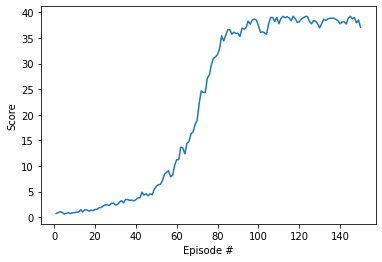

In [9]:
# Ploting the scores evolution during training.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Checking agent performance

In [ ]:
# Load actor and critic weights from file (if needed)
agent.actor_local.load_state_dict(torch.load('trained_actor-ddpg.pth'))
agent.critic_local.load_state_dict(torch.load('trained_critic-ddpg.pth'))

In [10]:
# Checking the performance of the trained agent
env_data = env.reset(train_mode=False)[brain_name]     # Reset environment
states = env_data.vector_observations                  # Get the first state (for each agent)
scores = np.zeros(num_agents)                          # Initialize the score (for each agent)

while True:
    actions = agent.act(states)                        # Get action from policy (one per agent)
    env_data = env.step(actions)[brain_name]           # Interaction with the environment
    next_states = env_data.vector_observations         # get next state (for each agent)
    rewards = env_data.rewards                         # get reward (for each agent)
    dones = env_data.local_done                        # See if episode finished
    scores += env_data.rewards                         # Add the reward to the total score (for each agent)
    states = next_states                               # Roll over states to next time step
    if np.any(dones):                                  # Exit loop if episode finished
        break
        
print('Smart Agent Score (averaged over all 20 agents): {:.2f}'.format(np.mean(scores)))

Smart Agent Score (averaged over all 20 agents): 37.60


In [11]:
# Taking random actions in the Environment
env_info = env.reset(train_mode=False)[brain_name]     # Reset the environment    
states = env_info.vector_observations                  # Get the first state (for each agent)
scores = np.zeros(num_agents)                          # Initialize the score (for each agent)

while True:
    actions = np.random.randn(num_agents, action_size) # eslect a random action (for each agent)
    actions = np.clip(actions, -1, 1)                  # Clip all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # Interaction with the environment
    next_states = env_info.vector_observations         # Get next state (for each agent)
    rewards = env_info.rewards                         # Get reward (for each agent)
    dones = env_info.local_done                        # See if episode finished
    scores += env_info.rewards                         # Update the score (for each agent)
    states = next_states                               # Roll over states to next time step
    if np.any(dones):                                  # Exit loop if episode finished
        break

print("Random Agent Score (averaged over all 20 agents): {:.2f}".format(np.mean(scores)))

Random Agent Score (averaged over all 20 agents): 0.23


### Closing the environment

In [12]:
# Closing the environment
env.close()